### Load and Explore the Dataset

We'll start by loading the dataset directly from an online source.

Note: This dataset was published by Mostafa Elmehy in Kaggle 2020 [https://www.kaggle.com/datasets/mostafaelmehy/ab-data]

In [4]:
import pandas as pd

# Load the dataset
url = 'https://raw.githubusercontent.com/abel-keya/Project-Analyze-A-B-Test-Results/master/ab_data.csv'
data = pd.read_csv(url)
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


#### Explore the data by calculating the conversion rate for each variant and describe what you see

In [6]:
conversion_rates = data.groupby('group')['converted'].mean()
print("Conversion Rates:")
print(conversion_rates)

Conversion Rates:
group
control      0.120399
treatment    0.118920
Name: converted, dtype: float64


We'll assume a Beta distribution as a prior, which is commonly used for binomial data.

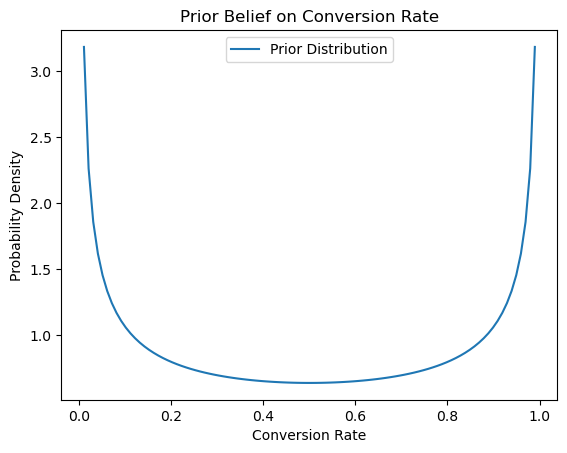

In [8]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
#matplotlib inline

# Prior belief parameters
alpha_prior, beta_prior = 0.5, 0.5

# Plot prior
x = np.linspace(0, 1, 100)
plt.plot(x, beta.pdf(x, alpha_prior, beta_prior), label="Prior Distribution")
plt.xlabel("Conversion Rate")
plt.ylabel("Probability Density")
plt.legend()
plt.title("Prior Belief on Conversion Rate")
plt.show()

#### Experiment by changing the values of alpha_prior and beta_prior. How does the shape of the prior change

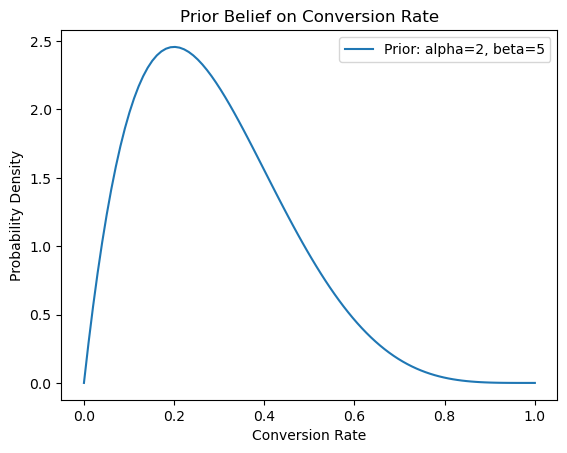

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Experiment with different prior parameters
alpha_prior = 2 
beta_prior = 5  

x = np.linspace(0, 1, 100)
plt.plot(x, beta.pdf(x, alpha_prior, beta_prior), label=f"Prior: alpha={alpha_prior}, beta={beta_prior}")
plt.xlabel("Conversion Rate")
plt.ylabel("Probability Density")
plt.title("Prior Belief on Conversion Rate")
plt.legend()
plt.show()


Increasing β (relative to α) shifts the distribution's mass toward smaller values of the conversion rate. Increasing both α and β makes the distribution more concentrated, reducing the uncertainty.

### Updating with Observed Data

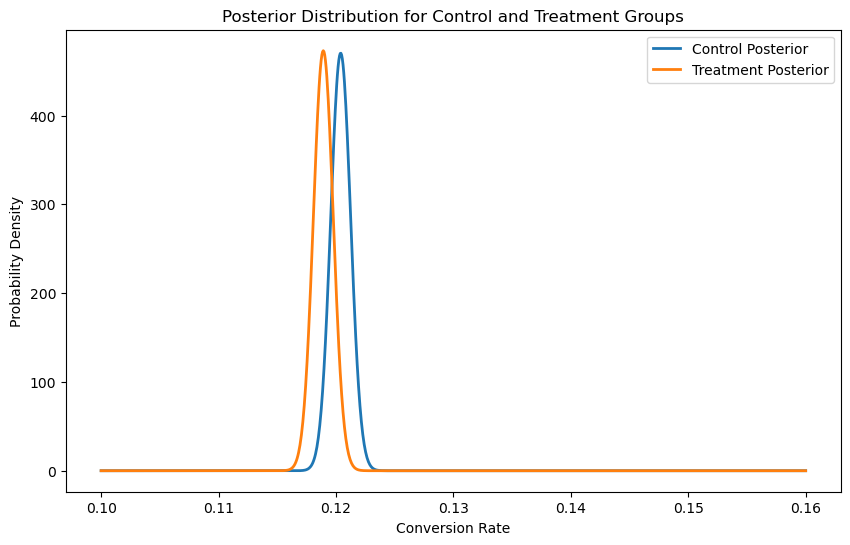

Control Posterior: α = 17724, β = 129480
Treatment Posterior: α = 17515, β = 129763


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

control_data = data[data['group'] == 'control']
treatment_data = data[data['group'] == 'treatment']

control_successes = control_data['converted'].sum()
control_failures = control_data['converted'].count() - control_successes

treatment_successes = treatment_data['converted'].sum()
treatment_failures = treatment_data['converted'].count() - treatment_successes

alpha_prior = 1 
beta_prior = 1
alpha_control_post = alpha_prior + control_successes
beta_control_post = beta_prior + control_failures
alpha_treatment_post = alpha_prior + treatment_successes
beta_treatment_post = beta_prior + treatment_failures

x = np.linspace(0.1, 0.16, 1000)

control_posterior = beta.pdf(x, alpha_control_post, beta_control_post)
treatment_posterior = beta.pdf(x, alpha_treatment_post, beta_treatment_post)

plt.figure(figsize=(10, 6))
plt.plot(x, control_posterior, label='Control Posterior', linewidth=2)
plt.plot(x, treatment_posterior, label='Treatment Posterior', linewidth=2)
plt.xlabel('Conversion Rate')
plt.ylabel('Probability Density')
plt.title('Posterior Distribution for Control and Treatment Groups')
plt.legend()
plt.show()

print(f"Control Posterior: α = {alpha_control_post}, β = {beta_control_post}")
print(f"Treatment Posterior: α = {alpha_treatment_post}, β = {beta_treatment_post}")

In [14]:
mean_control = alpha_control_post / (alpha_control_post + beta_control_post)
mean_treatment = alpha_treatment_post / (alpha_treatment_post + beta_treatment_post)

# Print the results
print(f"Mean Conversion Rate (Control): {mean_control:.4f}")
print(f"Mean Conversion Rate (Treatment): {mean_treatment:.4f}")

Mean Conversion Rate (Control): 0.1204
Mean Conversion Rate (Treatment): 0.1189


### Decision Making with Credible Intervals

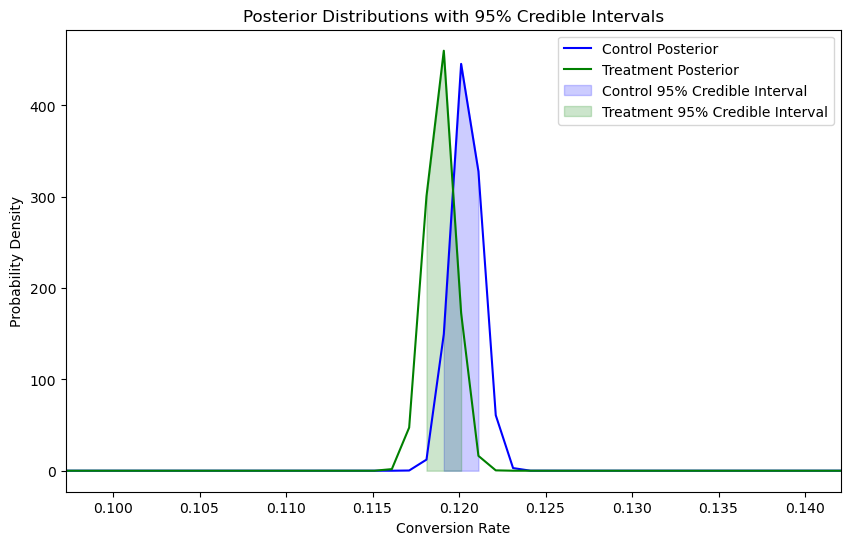

95% Credible Interval for Control Group: [0.1187, 0.1221]
95% Credible Interval for Treatment Group: [0.1173, 0.1206]


In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

# Calculate the posterior parameters
alpha_control_post = alpha_prior + control_successes
beta_control_post = beta_prior + control_failures

alpha_treatment_post = alpha_prior + treatment_successes
beta_treatment_post = beta_prior + treatment_failures

ci_control = beta.ppf([0.025, 0.975], alpha_control_post, beta_control_post)
ci_treatment = beta.ppf([0.025, 0.975], alpha_treatment_post, beta_treatment_post)

x = np.linspace(0, 1, 1000)

control_posterior = beta.pdf(x, alpha_control_post, beta_control_post)
treatment_posterior = beta.pdf(x, alpha_treatment_post, beta_treatment_post)

x_min = min(ci_control[0], ci_treatment[0]) - 0.02
x_max = max(ci_control[1], ci_treatment[1]) + 0.02

# Plot posterior distributions
plt.figure(figsize=(10, 6))
plt.plot(x, control_posterior, label="Control Posterior", color="blue")
plt.plot(x, treatment_posterior, label="Treatment Posterior", color="green")

plt.fill_between(x, 0, control_posterior,
                 where=(x >= ci_control[0]) & (x <= ci_control[1]), color="blue", alpha=0.2,
                 label="Control 95% Credible Interval")
plt.fill_between(x, 0, treatment_posterior,
                 where=(x >= ci_treatment[0]) & (x <= ci_treatment[1]), color="green", alpha=0.2,
                 label="Treatment 95% Credible Interval")

plt.xlim(x_min, x_max)

plt.xlabel("Conversion Rate")
plt.ylabel("Probability Density")
plt.title("Posterior Distributions with 95% Credible Intervals")
plt.legend()
plt.show()

print(f"95% Credible Interval for Control Group: [{ci_control[0]:.4f}, {ci_control[1]:.4f}]")
print(f"95% Credible Interval for Treatment Group: [{ci_treatment[0]:.4f}, {ci_treatment[1]:.4f}]")


The 95% credible intervals for the control group[0.1187,0.1221] and the treatment group [0.1173,0.1206] overlap significantly, indicating that the true conversion rates for both groups are likely similar. This overlap suggests there is no strong evidence to conclude that the treatment (new page) is more effective than the control (old page) in improving conversion rates. The similarity in the intervals implies that the new page did not have a statistically significant impact, and further analysis, such as hypothesis testing or Bayes factor evaluation, would be needed to confirm these results.

### Experimenting with Different Priors

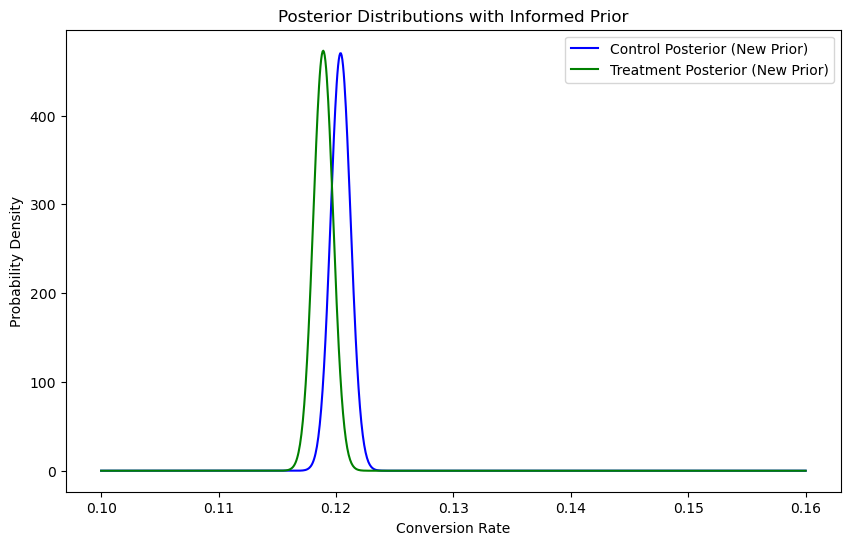

Control Posterior Parameters: α = 17725, β = 129497
Treatment Posterior Parameters: α = 17516, β = 129780


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

alpha_prior = 2
beta_prior = 18
alpha_control_post = alpha_prior + control_successes
beta_control_post = beta_prior + control_failures

alpha_treatment_post = alpha_prior + treatment_successes
beta_treatment_post = beta_prior + treatment_failures

x = np.linspace(0.1, 0.16, 1000)
control_posterior = beta.pdf(x, alpha_control_post, beta_control_post)
treatment_posterior = beta.pdf(x, alpha_treatment_post, beta_treatment_post)

plt.figure(figsize=(10, 6))
plt.plot(x, control_posterior, label="Control Posterior (New Prior)", color="blue")
plt.plot(x, treatment_posterior, label="Treatment Posterior (New Prior)", color="green")
plt.xlabel("Conversion Rate")
plt.ylabel("Probability Density")
plt.title("Posterior Distributions with Informed Prior")
plt.legend()
plt.show()

print(f"Control Posterior Parameters: α = {alpha_control_post}, β = {beta_control_post}")
print(f"Treatment Posterior Parameters: α = {alpha_treatment_post}, β = {beta_treatment_post}")


The new prior, reflecting prior knowledge of a 10% conversion rate, has shifted the posterior distributions closer to the prior mean, slightly pulling the results toward 0.1 compared to the original uniform prior. This influence is particularly evident in the treatment group, whose posterior mean is now more aligned with the prior belief. Additionally, the new posterior distributions are narrower, reflecting reduced uncertainty due to the moderate confidence introduced by the prior. Despite this adjustment, the relative comparison between the control and treatment groups remains consistent, with the control group still exhibiting a slightly higher conversion rate. Overall, the new prior has made the posterior results more conservative, balancing observed data with prior knowledge.